# Transfer learning and fine-tuning

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import seaborn as sns
import tensorflow as tf

## Data preprocessing

### Data download

In [2]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

BATCH_SIZE = 128
IMG_SIZE = (160, 160)

train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

68606236/68606236 [==============================] - 0s 0us/step
Found 2000 files belonging to 2 classes.


In [3]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 1000 files belonging to 2 classes.


Show the first nine images and labels from the training set:

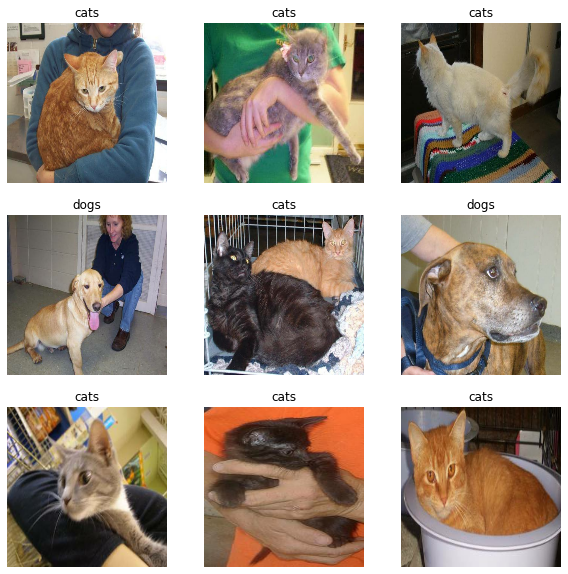

In [4]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

As the original dataset doesn't contain a test set, you will create one. To do so, determine how many batches of data are available in the validation set using `tf.data.experimental.cardinality`, then move 20% of them to a test set.

In [5]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

In [6]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 7
Number of test batches: 1


### Configure the dataset for performance

Use buffered prefetching to load images from disk without having I/O become blocking. To learn more about this method see the [data performance](https://www.tensorflow.org/guide/data_performance) guide.

In [7]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

### Use data augmentation

In [8]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

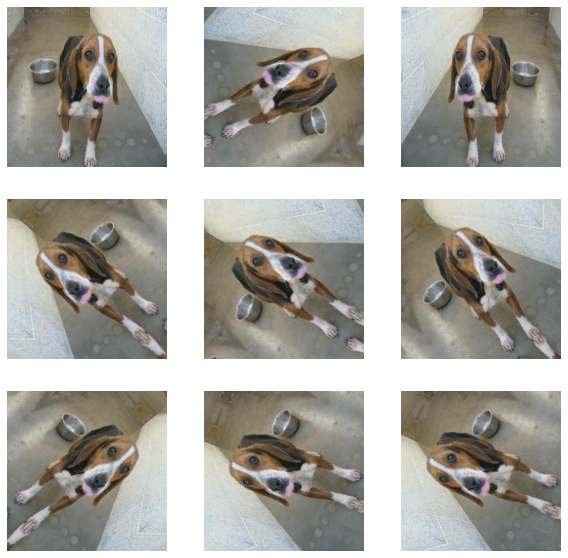

In [9]:
# augmentation sample
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [10]:
### REPLACE THIS FOR NEW MODEL! (1)

preprocess_input = tf.keras.applications.mobilenet.preprocess_input

Note: Alternatively, you could rescale pixel values from `[0, 255]` to `[-1, 1]` using `tf.keras.layers.Rescaling`.

In [11]:
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

Note: If using other `tf.keras.applications`, be sure to check the API doc to determine if they expect pixels in `[-1, 1]` or `[0, 1]`, or use the included `preprocess_input` function.

## Create the base model from the pre-trained convnets

In [12]:
# Create the base model from the pre-trained model MobileNet
# REPLACE THIS FOR NEW MODEL e.g. EfficientNet (2)

IMG_SHAPE = IMG_SIZE + (3,)
# base_model = create_model()
base_model = tf.keras.applications.MobileNet(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

17225924/17225924 [==============================] - 0s 0us/step


In [13]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(128, 5, 5, 1024)


## Feature extraction

### Freeze the convolutional base

In [14]:
base_model.trainable = False

In [15]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "mobilenet_1.00_160"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 80, 80, 32)        864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 80, 80, 32)       128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 80, 80, 32)        0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 80, 80, 32)       288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 80, 80, 32)       128       
 ation)                                         

### Add a classification head

In [16]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(128, 1024)


In [17]:
# (3)  Change this

prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(128, 1)


In [18]:
# As previously mentioned, use training=False as our model contains a BatchNormalization layer.

inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

### Compile the model

In [19]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [20]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 160, 160, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 160, 160, 3)      0         
 a)                                                              
                                                                 
 mobilenet_1.00_160 (Functio  (None, 5, 5, 1024)       3228864   
 nal)                                                            
                                                             

In [21]:
len(model.trainable_variables)

2

### Train the model


In [22]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_dataset)

7/7 [==============================] - 6s 195ms/step - loss: 1.0279 - accuracy: 0.4197


In [23]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 1.03
initial accuracy: 0.42


In [24]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10


16/16 [==============================] - 18s 784ms/step - loss: 0.9405 - accuracy: 0.4710 - val_loss: 0.8576 - val_accuracy: 0.4644
Epoch 2/10
16/16 [==============================] - 13s 764ms/step - loss: 0.8411 - accuracy: 0.5325 - val_loss: 0.7755 - val_accuracy: 0.5287
Epoch 3/10
16/16 [==============================] - 13s 752ms/step - loss: 0.7663 - accuracy: 0.5665 - val_loss: 0.6894 - val_accuracy: 0.5952
Epoch 4/10
16/16 [==============================] - 14s 787ms/step - loss: 0.7252 - accuracy: 0.5895 - val_loss: 0.6242 - val_accuracy: 0.6502
Epoch 5/10
16/16 [==============================] - 14s 759ms/step - loss: 0.6619 - accuracy: 0.6405 - val_loss: 0.5638 - val_accuracy: 0.7144
Epoch 6/10
16/16 [==============================] - 13s 756ms/step - loss: 0.6168 - accuracy: 0.6630 - val_loss: 0.5159 - val_accuracy: 0.7431
Epoch 7/10
16/16 [==============================] - 13s 765ms/step - loss: 0.5643 - accuracy: 0.6940 - val_loss: 0.4740 - val_accuracy: 0.7626
Epoch 8/10

### Learning curves

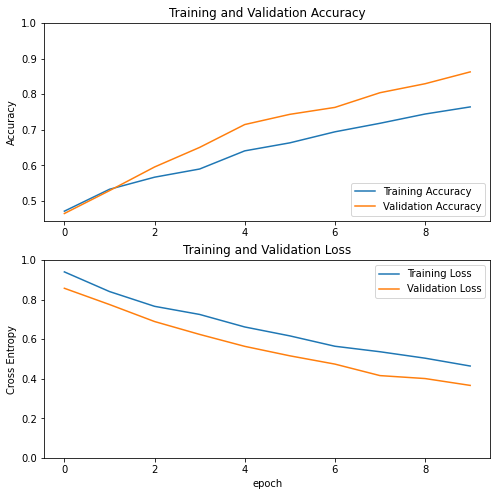

In [25]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

los = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(los, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

Note: If you are wondering why the validation metrics are clearly better than the training metrics, the main factor is because layers like `tf.keras.layers.BatchNormalization` and `tf.keras.layers.Dropout` affect accuracy during training. They are turned off when calculating validation loss.

To a lesser extent, it is also because training metrics report the average for an epoch, while validation metrics are evaluated after the epoch, so validation metrics see a model that has trained slightly longer.

## Fine tuning


### Un-freeze the top layers of the model


In [26]:
base_model.trainable = True

In [27]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = len(base_model.layers)//2
print("fine_tune_at: ", fine_tune_at)

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  86
fine_tune_at:  43


### Compile the model

In [28]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

In [29]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 160, 160, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 160, 160, 3)      0         
 a)                                                              
                                                                 
 mobilenet_1.00_160 (Functio  (None, 5, 5, 1024)       3228864   
 nal)                                                            
                                                             

In [30]:
len(model.trainable_variables)

44

### Continue training the model

In [31]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 10/20


16/16 [==============================] - 24s 846ms/step - loss: 0.3553 - accuracy: 0.8350 - val_loss: 0.1539 - val_accuracy: 0.9599
Epoch 11/20
16/16 [==============================] - 14s 735ms/step - loss: 0.2235 - accuracy: 0.9045 - val_loss: 0.1169 - val_accuracy: 0.9690
Epoch 12/20
16/16 [==============================] - 14s 792ms/step - loss: 0.1984 - accuracy: 0.9160 - val_loss: 0.0981 - val_accuracy: 0.9713
Epoch 13/20
16/16 [==============================] - 13s 789ms/step - loss: 0.1536 - accuracy: 0.9390 - val_loss: 0.0787 - val_accuracy: 0.9702
Epoch 14/20
16/16 [==============================] - 14s 796ms/step - loss: 0.1630 - accuracy: 0.9320 - val_loss: 0.0971 - val_accuracy: 0.9748
Epoch 15/20
16/16 [==============================] - 15s 819ms/step - loss: 0.1290 - accuracy: 0.9435 - val_loss: 0.0734 - val_accuracy: 0.9713
Epoch 16/20
16/16 [==============================] - 15s 813ms/step - loss: 0.1212 - accuracy: 0.9485 - val_loss: 0.0670 - val_accuracy: 0.9748
Epoc

In [32]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

los += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

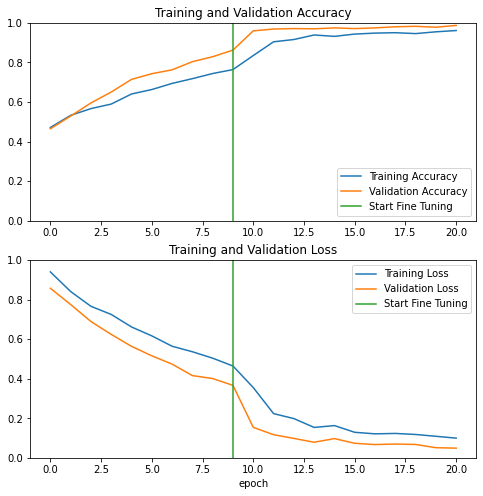

In [33]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(los, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### Evaluation and prediction

In [34]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

1/1 [==============================] - 1s 898ms/step - loss: 0.0528 - accuracy: 0.9844
Test accuracy : 0.984375


And now you are all set to use this model to predict if your pet is a cat or dog.

Predictions:
 [1 1 1 1 0 0 0 1 1 0 1 0 1 1 1 1 1 1 0 1 1 0 1 1 0 1 0 1 1 1 1 0 1 1 0 0 1
 1 1 0 0 1 1 0 0 0 0 0 1 0 1 1 0 0 1 1 0 1 0 0 1 0 0 1 0 0 1 1 0 1 0 0 0 1
 0 0 0 1 1 1 0 0 1 1 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 1 1 0 0 1 0 1 1 0 1 1 1
 1 1 1 0 1 1 1 1 1 1 0 1 0 1 1 0 0]
Labels:
 [0 1 1 1 0 0 0 1 1 0 1 0 1 1 1 1 1 1 0 1 1 0 1 1 0 1 0 1 1 1 1 0 1 1 0 0 1
 1 1 0 0 1 1 0 0 0 0 0 1 0 1 1 0 0 1 0 0 1 0 0 1 0 0 1 0 0 1 1 0 1 0 0 0 1
 0 0 0 1 1 1 0 0 1 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 1 1 0 0 1 0 1 1 0 1 1 1
 1 1 1 0 1 1 1 1 1 1 0 1 0 1 1 0 0]


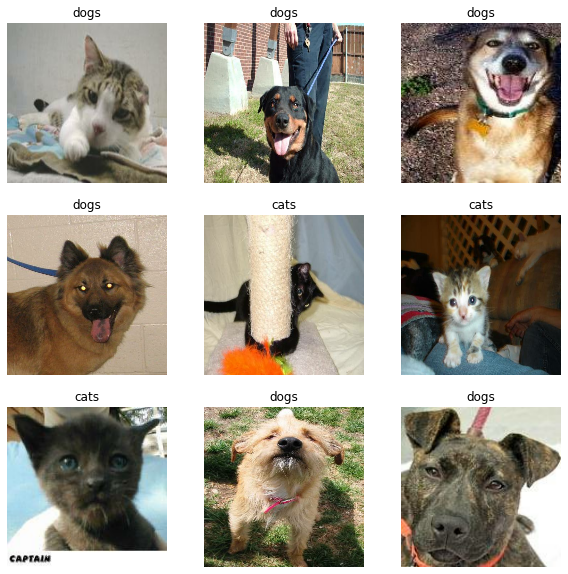

In [35]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

# Confusion Matrix

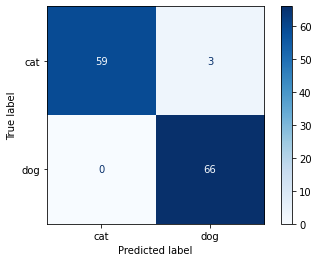

In [36]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

labels = ['cat', 'dog']

cm = confusion_matrix(label_batch, predictions.numpy())
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)
plt.show()


In [37]:
from sklearn.metrics import classification_report

print(classification_report(label_batch, predictions.numpy(), target_names=labels))

              precision    recall  f1-score   support

         cat       1.00      0.95      0.98        62
         dog       0.96      1.00      0.98        66

    accuracy                           0.98       128
   macro avg       0.98      0.98      0.98       128
weighted avg       0.98      0.98      0.98       128



## Summary

* **Using a pre-trained model for feature extraction**:  When working with a small dataset, it is a common practice to take advantage of features learned by a model trained on a larger dataset in the same domain. This is done by instantiating the pre-trained model and adding a fully-connected classifier on top. The pre-trained model is "frozen" and only the weights of the classifier get updated during training.
In this case, the convolutional base extracted all the features associated with each image and you just trained a classifier that determines the image class given that set of extracted features.

* **Fine-tuning a pre-trained model**: To further improve performance, one might want to repurpose the top-level layers of the pre-trained models to the new dataset via fine-tuning.
In this case, you tuned your weights such that your model learned high-level features specific to the dataset. This technique is usually recommended when the training dataset is large and very similar to the original dataset that the pre-trained model was trained on.

To learn more, visit the [Transfer learning guide](https://www.tensorflow.org/guide/keras/transfer_learning).
